In [1]:
from keras.layers import  Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from math import floor
import os
import cv2 as cv

In [2]:
datapath="C:/Users/ASUS/Downloads/archive (5)/chest_xray/"

In [3]:
IMAGE_SIZE = [224, 224]

training_path = r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\train"
validation_path= r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\val"
testing_path=r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\test"

In [4]:
mobilenet_v2 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
for layer in mobilenet_v2.layers:
    layer.trainable = False

In [6]:
folders_classes = glob(r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\train\*")
print(len(folders_classes))

2


In [7]:
output_prediction = Flatten()(mobilenet_v2.output)

In [8]:
prediction_pneumonia= Dense(len(folders_classes), activation='softmax')(output_prediction)

model_mobile = Model(inputs=mobilenet_v2.input, outputs=prediction_pneumonia)

In [9]:
model_mobile.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
model_mobile.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

training_generator_images = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.2,

)
valid_generator_images=ImageDataGenerator(
    rescale = 1. / 255,
    )

In [12]:
training_set_images = training_generator_images.flow_from_directory(r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\train",
                                            target_size = (224, 224),
                                            batch_size = 15,
                                          class_mode = 'categorical',
                                          )

Found 5216 images belonging to 2 classes.


In [13]:
validation_set_images = valid_generator_images.flow_from_directory(r"C:\Users\ASUS\Downloads\archive (5)\chest_xray\val",
                                            target_size = (224, 224),
                                            batch_size = 15,
                                            class_mode = 'categorical',
                                            )

Found 16 images belonging to 2 classes.


In [14]:
training_set_images.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
img_dims = 150
epochs = 10
batch_size = 32

In [16]:
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [17]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [18]:
mobilev2_r = model_mobile.fit(
  training_set_images,
  validation_data=validation_set_images,
  epochs=10,
  steps_per_epoch=len(training_set_images),
  validation_steps=len(validation_set_images),
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/10
348/348 [==============================] - 194s 543ms/step - loss: 1.0263 - accuracy: 0.9281 - val_loss: 0.6222 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/10
348/348 [==============================] - 178s 511ms/step - loss: 0.8411 - accuracy: 0.9528 - val_loss: 1.1250e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
348/348 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.9517
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
348/348 [==============================] - 176s 504ms/step - loss: 1.0043 - accuracy: 0.9517 - val_loss: 0.2125 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/10
348/348 [==============================] - 199s 572ms/step - loss: 0.4900 - accuracy: 0.9757 - val_loss: 0.7254 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 5/10
348/348 [==============================] - 212s 609ms/step - loss: 0.4133 - accuracy: 0.9755 - val_loss: 0.0862 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 6/10
348/348 [============

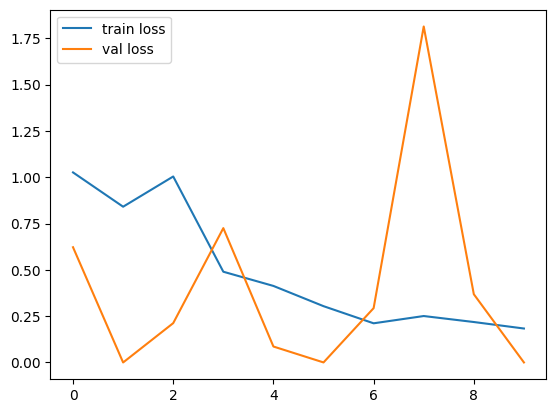

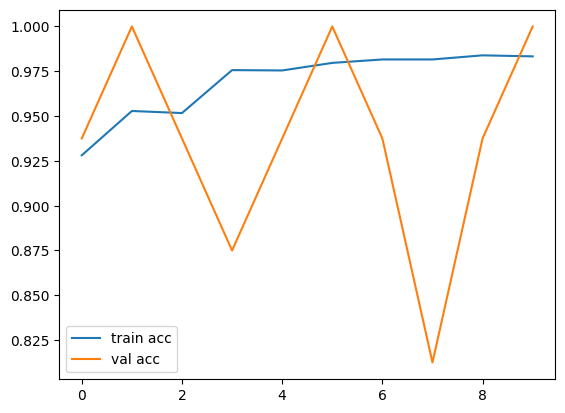

<Figure size 640x480 with 0 Axes>

In [19]:
plt.plot(mobilev2_r.history['loss'], label='train loss')
plt.plot(mobilev2_r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


plt.plot(mobilev2_r.history['accuracy'], label='train acc')
plt.plot(mobilev2_r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

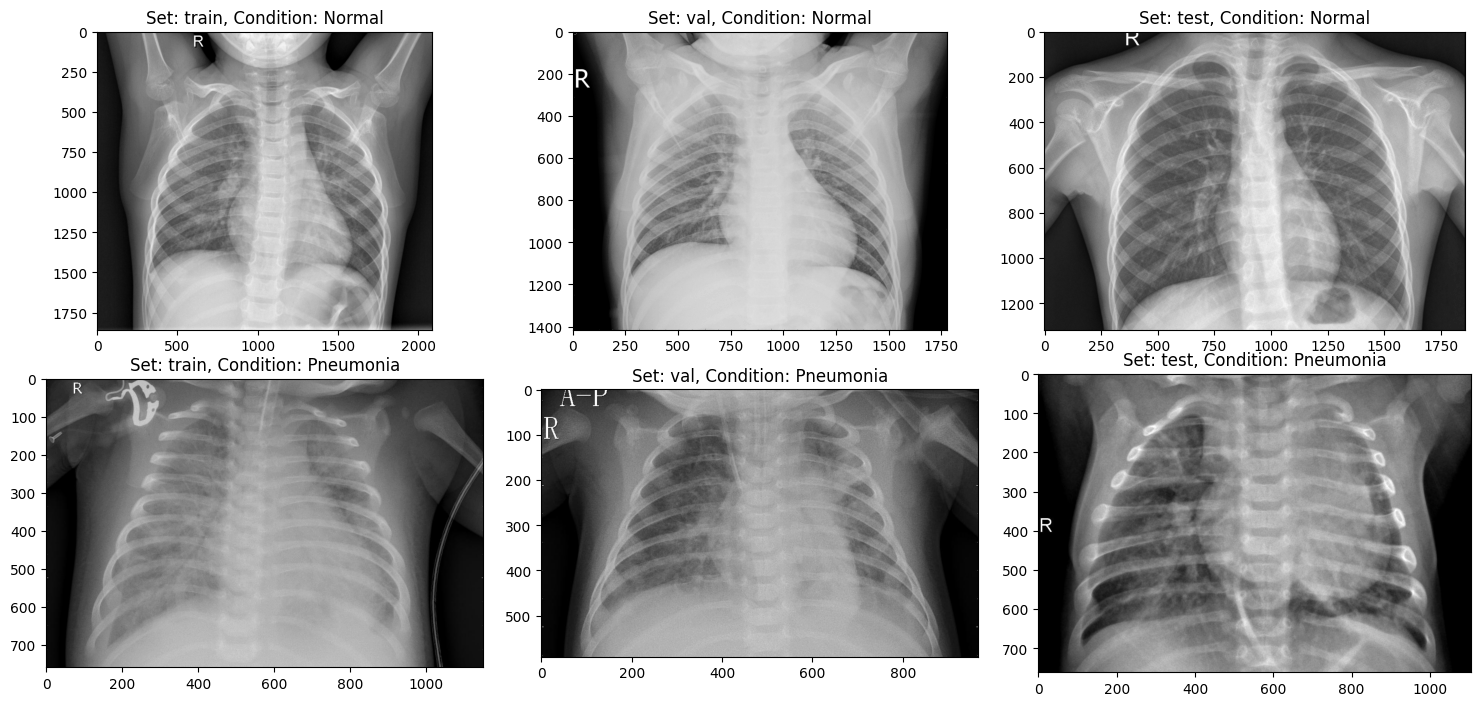

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = datapath+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [21]:
y_actual_values=[]
y_test_values=[]

In [22]:
from tensorflow.keras.preprocessing import image

In [23]:
import os
for i in os.listdir("C:/Users/ASUS/Downloads/archive (5)/chest_xray/test/NORMAL/"):
    img=image.load_img("C:/Users/ASUS/Downloads/archive (5)/chest_xray/test/NORMAL/" +i,target_size=(224,224))
    x_to_arr=image.img_to_array(img)
    x_expand=np.expand_dims(x_to_arr,axis=0)
    img_data=preprocess_input(x_expand)
    model_prediction=model_mobile.predict(img_data)
    predicted=np.argmax(model_prediction, axis=1)
    if(predicted[0]==0):
        y_test_values.append(0)
    else:
        y_test_values.append(1)
    
    y_actual_values.append(0)

1/1 [==============================] - 0s 64ms/step


In [24]:
for i in os.listdir("C:/Users/ASUS/Downloads/archive (5)/chest_xray/test/PNEUMONIA/"):
    img=image.load_img("C:/Users/ASUS/Downloads/archive (5)/chest_xray/test/PNEUMONIA/"+i,target_size=(224,224))
    x_to_arr=image.img_to_array(img)
    x_expand=np.expand_dims(x_to_arr,axis=0)
    img_data=preprocess_input(x_expand)
    model_prediction=model_mobile.predict(img_data)
    predicted=np.argmax(model_prediction, axis=1)
    if(predicted[0]==1):
        y_test_values.append(1)
    else:
        y_test_values.append(0)
        
    y_actual_values.append(1)

1/1 [==============================] - 0s 59ms/step


In [25]:
y_actual_values=np.array(y_actual_values)
y_test_values=np.array(y_test_values)

In [26]:
print(y_actual_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [27]:
print(y_test_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

[[200  34]
 [ 15 375]]


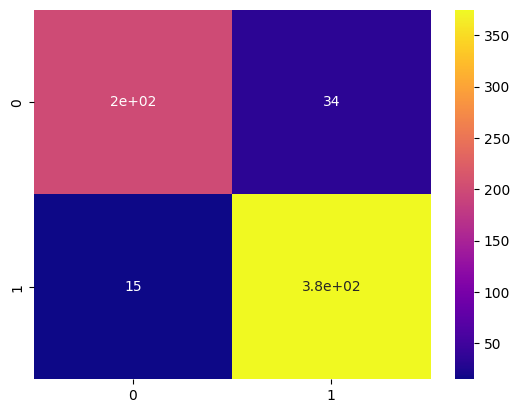

In [28]:
from sklearn.metrics import confusion_matrix
confusion_m=confusion_matrix(y_actual_values,y_test_values)
import seaborn as sns
sns.heatmap(confusion_m,cmap="plasma",annot=True)
print(confusion_m)

In [29]:
from sklearn import metrics
print(metrics.classification_report(y_actual_values,y_test_values,digits=4))

              precision    recall  f1-score   support

           0     0.9302    0.8547    0.8909       234
           1     0.9169    0.9615    0.9387       390

    accuracy                         0.9215       624
   macro avg     0.9236    0.9081    0.9148       624
weighted avg     0.9219    0.9215    0.9207       624



In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_actual_values, y_test_values)

0.9214743589743589

In [ ]:
# The main goal of MobileNetV2 is to achieve high accuracy on image classification tasks 
#while reducing the number of parameters and computational complexity.